In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create known parameters
weight = 0.7
bias = 0.3

# create some data
start = 0
end = 1
gap = 0.02
X = torch.arange(start, end, gap).unsqueeze(dim=1)
Y = weight * X + bias

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

In [3]:
# We take 80% of it
train_split = int(0.8*len(X))
X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

### Visuallize our data

In [4]:
def plot_predictions(train_data = X_train, train_labels = Y_train, test_data = X_test, test_labels = Y_test, predictions = None):

    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label="Training Data")

    # Plot testing data in green
    plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

    # Are they predictions?
    if predictions is not None:
        
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")
    
    #Show the legends
    plt.legend(prop={"size":14});


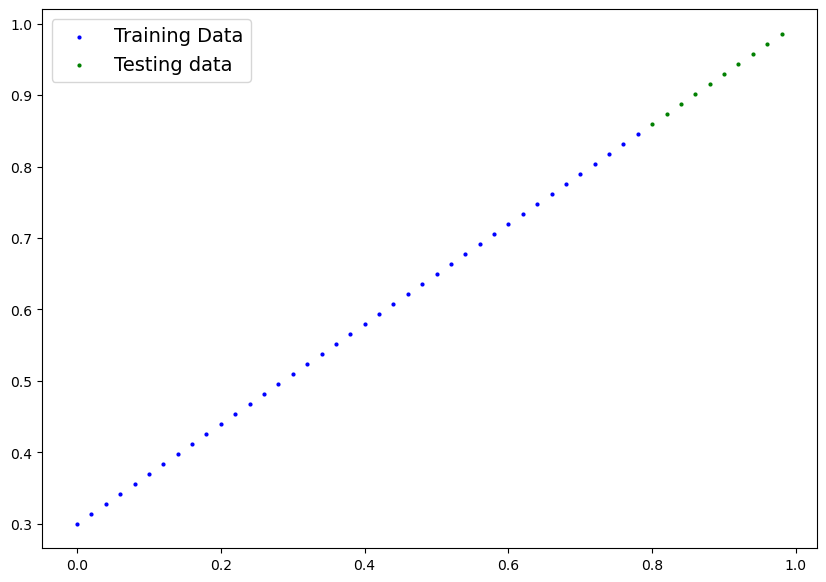

In [5]:
plot_predictions()

### Building our model
**Our first model!!**

#### What our model will do:
* Start with a random number
* Look at training data and adjust the random values to better represent the ideal values

#### How does it do so?
1. Gradient descent
2. Backpropadation

In [6]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### Making predictions we using `torch.inference_mode()`

In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an ibstance of the model 
model0 = LinearRegressionModel()

## Make predictions with model
with torch.inference_mode(): 
    Y_preds = model0(X_test)

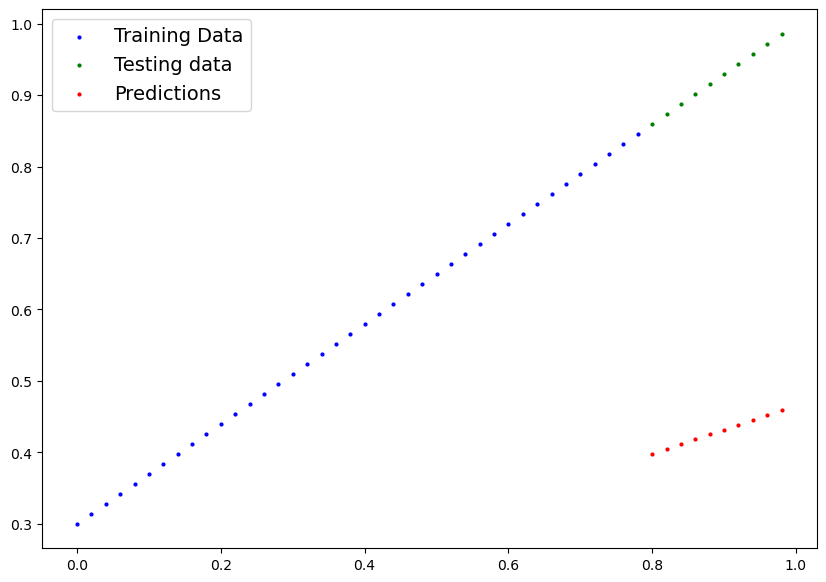

In [8]:
# Plot predictions
plot_predictions(predictions=Y_preds)

### Train model

Thew hole idea of training is for a model from some *unknown* parameter to some *known* parameter.

Or in other words from  poor representation of the data to a better representation of the data.

One way to measure how wrong our models predictions are isto use *loss* function.

In [9]:
model0.state_dict(), model0.parameters()

(OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]),
 <generator object Module.parameters at 0x13a2eda80>)

Things we need to train:
 * Optimizer
    * Inside the optimizer you will often have to set two parameters:
      * `params` - the model parameters you would like to optimize, for example `params = model0_parameters()`
      * `lr` - learning rate define how big/small thr optimizer changes the parameters with each step
 * Loss Function

 And specifically for PyTorch we need:
 * A training loop
 * A testing loop

In [10]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Setup a optimizer
optimizer = torch.optim.Adam(params=model0.parameters(), # parameters of target model to optimize
                            lr=0.001) # learning rate

### Building a training loop and a test loop in PyTorch

A couple things we need on a training loop:
0. Loop through the data
1. Forward pass (this invovles data moving through our model's `foward()` functions) to make predictions on data - also called foward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backworads through the network to caculate the gradient of each of parameters of our model with respect to the loss **back propagation**
5. Optimizer Step - use the optmizer to adjust our model's parameter to try and improve the loss **gradient descent**

In [11]:
# An epoch is one loop through the data
epochs = 1000

# Create some arrays to save result to visuallize it
train_loss_curves = np.zeros(shape=epochs)
test_loss_curves = np.zeros(shape=epochs)
epochs_times = np.arange(start=1, stop=epochs+1, step=1)


# Loop through the data
for epoch in range(epochs):
    # Set the model to training moode
    model0.train() # train mode in PyTorch sets all parameter that require gradients to require

    # 1. Forward pass
    Y_preds = model0(X_train)

    # 2. Caculate the loss
    loss = loss_fn(Y_preds, Y_train)
    train_loss_curves[epoch-1] = loss
    # print(f"loss:", loss)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform back propagation on the loss with respect to the parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # By default how the optimizer changes will acculumate through the loop. So we have to zero out at step three.

    ### Testing
    model0.eval() # Turn off gradient tracking

    with torch.inference_mode(): # Turns off gradient tracking & a couple more things behind the scenes
        # 1. Forward pass
        test_pred = model0(X_test)

        # 2. Caculate the loss
        test_loss = loss_fn(test_pred, Y_test)
        test_loss_curves[epoch-1] = test_loss
    
    if epoch % 100 == 0:
        print(f"Epochs: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    ### Print out our model state_dict()
    #print(model0.state_dict())

Epochs: 0 | Loss: 0.31288138031959534 | Test loss: 0.49264615774154663
Epochs: 100 | Loss: 0.1738816499710083 | Test loss: 0.30364710092544556
Epochs: 200 | Loss: 0.04391415789723396 | Test loss: 0.11851052939891815
Epochs: 300 | Loss: 0.01987886242568493 | Test loss: 0.04284300282597542
Epochs: 400 | Loss: 0.01082777138799429 | Test loss: 0.02373359724879265
Epochs: 500 | Loss: 0.0005631580715999007 | Test loss: 0.000985985971055925
Epochs: 600 | Loss: 0.00010655373625922948 | Test loss: 0.00015099644951988012
Epochs: 700 | Loss: 0.00039451493648812175 | Test loss: 0.0008820295333862305
Epochs: 800 | Loss: 0.0003310695174150169 | Test loss: 0.0006135046714916825
Epochs: 900 | Loss: 0.0002042330743279308 | Test loss: 0.0005049646133556962


### Visualize the loss curves

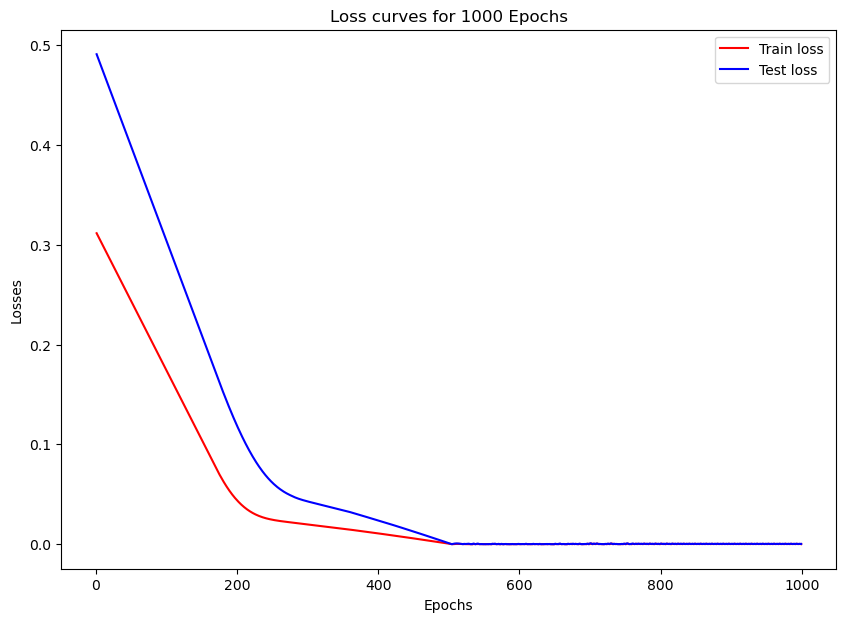

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(epochs_times[:-1], train_loss_curves[:-1], c='r', label="Train loss")
plt.plot(epochs_times[:-1], test_loss_curves[:-1], c='b', label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.title("Loss curves for 1000 Epochs")
plt.show;

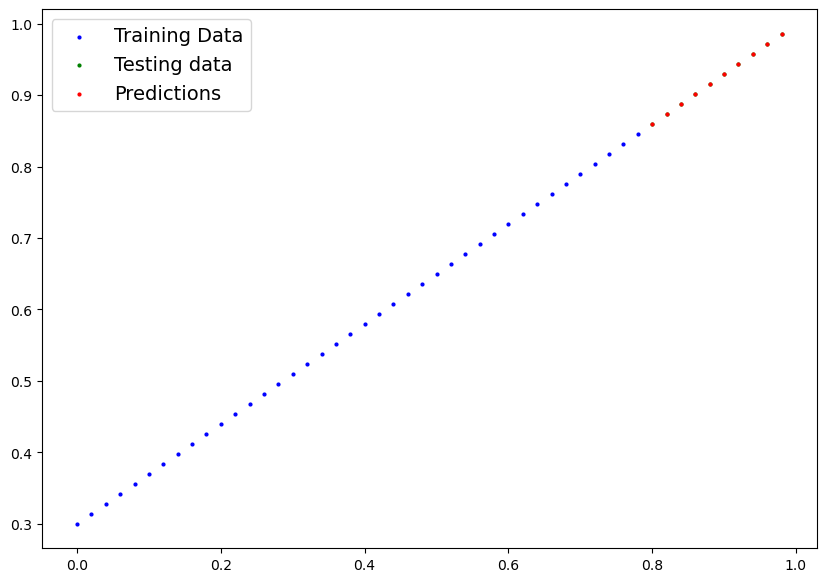

In [13]:
with torch.inference_mode():
    Y_pred_new = model0(X_test)

plot_predictions(predictions=Y_pred_new)

In [14]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6999])), ('bias', tensor([0.2998]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3
